# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import scikitplot as skplt
from scipy.stats import chi2_contingency

from boruta import BorutaPy

from tabulate import tabulate

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from IPython.display import Image

import pickle

import time

# Tempo de processamento
time_agora = time.time()

###### 0.1 Helper Functions

In [2]:
# Função buscar outlier pelo método do 6 Sigma
def buscar_outlier(df, series):
    média = df[series].mean()
    desvio_padrão = df[series].std()
    lis = média - (desvio_padrão * 3)
    lss = média + (desvio_padrão * 3)
    lista_outliers = df[(df[series] < lis) | (df[series] > lss)].index
    return lista_outliers, lis, lss

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/( min(kcorr-1, rcorr-1)))

###### 0.3 Loading Dataset

In [3]:
df_raw = pd.read_csv(r'D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\raw\\train.csv')

test = df_raw.sample(frac=0.1)
test_indices = test.index
df = df_raw.drop(test_indices)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0


# 1.0 Data Description

In [4]:
df1 = df.copy()

### 1.1 Columns to Lowercase

In [5]:
cols = ' '.join(df1.columns.to_list()).lower().split()

df1.columns = cols

### 1.2 Data Dimensions

In [6]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 342998
Number of columns: 12


### 1.3 Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

### 1.4 Check Na

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### 1.5 Descriptive Statistical

###### 1.5.1 Classifying Attributes

In [9]:
categorical_attributes = ['gender', 'vehicle_damage', 'vehicle_age', 'driving_license', 'region_code', 'previously_insured', 'policy_sales_channel', 'vintage']
numerical_attributes = ['age', 'annual_premium']

###### 1.5.2 Target

In [10]:
print(f'A porcentagem de interessados no produto é: {round(df1["response"].mean(), 2) * 100} %')

A porcentagem de interessados no produto é: 12.0 %


Desbalanceada

###### 1.5.3 Numerical Features

In [11]:
# Central tendency
ct1 = pd.DataFrame(df1[numerical_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(df1[numerical_attributes].apply(np.median)).T

# Dispersion
d1 = pd.DataFrame(df1[numerical_attributes].apply(np.std)).T
d2 = pd.DataFrame(df1[numerical_attributes].apply(min)).T
d3 = pd.DataFrame(df1[numerical_attributes].apply(max)).T
d4 = pd.DataFrame(df1[numerical_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df1[numerical_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1[numerical_attributes].apply(lambda x: x.kurtosis())).T

# Concat
temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
age,20.0,85.0,65.0,38.812331,36.0,15.516712,0.673674,-0.565294
annual_premium,2630.0,540165.0,537535.0,30559.240136,31658.5,17202.199667,1.783140,34.486114


* Range de idade entre 20 e 85 anos, sem indícios de erros de inputs
* Annual_Premium com possíveis outliers

In [12]:
df1[numerical_attributes].describe().T

,count,mean,std,min,25%,50%,75%,max
age,342998.0,38.812331,15.516734,20.0,25.0,36.0,49.0,85.0
annual_premium,342998.0,30559.240136,17202.224744,2630.0,24410.0,31658.5,39382.0,540165.0


* Idade com média e mediana próximas, dados centralizados na média, skew baixa, o que reforça distribuição centralizada na média, skew pouco positiva, o que sugere cauda esquerda mais pesada, kurtosis baixa e negativa, o que sugere uma distribuição um pouco mais plana em relação a uma normal com mesma média e desvio padrão, uma distribuição próxima a uma NORMAL
* Prêmio Anual com média e mediana próximos, o que sugere dados centralizados na média, skew baixa e positiva, o que sugere dados centralizados na média com uma cauda esquerda mais pesada, kurtosis bastante alto, o que sugere um pico bastante elevado, uma distribuição próxima a uma POISSON

###### 1.5.4 Categorical Features

In [13]:
df1[categorical_attributes].astype('category').describe().T

,count,unique,top,freq
gender,342998,2,Male,185446
vehicle_damage,342998,2,Yes,173021
vehicle_age,342998,3,1-2 Year,180122
driving_license,342998,2,1,342279
region_code,342998.0,53.0,28.0,95686.0
previously_insured,342998,2,0,185760
policy_sales_channel,342998.0,154.0,152.0,121462.0
vintage,342998,290,73,1284


* Sexo relativamente balanceado com a maioria de mulheres
* Maior parte dos clientes possuem veículos com menos de 1 ano
* Maior parte dos clientes já teve danos em seu veículo
* Habilitação para dirigir balanceado
* Há 53 regiões diferentes e por volta de 30% dos clientes estão contidos na região 28
* Um pouco mais que 50% dos clientes não possuem seguro veicular
* Há 157 canais de vendas, e por volta de 35% dos clientes estão contidos no canal 152.

# 2.0 Feature Engineering

In [14]:
df2 = df1.copy()

### 2.1 Business Hypothesis

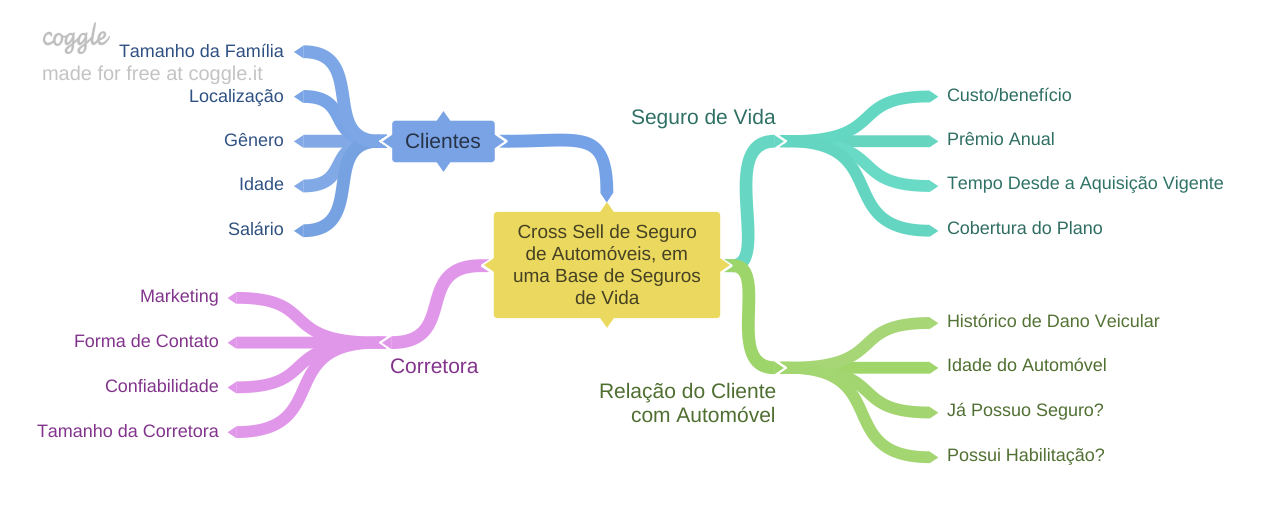

In [15]:
Image('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\img\\mindmap.JPG')

### 2.2 Creating Hypothesis

###### Corretora:
* Contatos mais diretos com os clientes deveriam gerar mais vendas
* Ações de marketing deveriam gerar mais vendas.
* Contato mais próximo com o cliente deveriam gerar mais vendas
* Maior confiabilidade da parte da corretora deveria gerar mais vendas.

###### Clientes:
* Clientes localizados em regiões com maiores rendas percaptas deveriam comprar mais
* Clientes do gênero feminino deveriam comprar mais
* Clientes mais velhos deveriam comprar mais
* Clientes com famílias maiores deveriam comprar mais

###### Seguro de Vida:
* Contas de Seguro de Vida com valores mais altos deveriam gerar mais vendas
* Contas com tempo de aquisição vigente maior deveriam gerar mais vendas

###### Relação do Cliente com o Automóvel:
* Clientes que já acionaram o seguro no passado deveriam comprar mais
* Clientes com veículos mais novos deveriam comprar mais
* Clientes que não possuem seguro de automóvel deveriam comprara mais.
* Clientes habilitados deveriam comprar mais.

###### Hipóteses Selecionadas:

### 2.3 Creating Features

# 3.0 Exploratory Data Analysis

In [16]:
df3 = df2.copy()

## 3.1 Principais Insights:

###### Response:
* Desbalanceada com 12% de eventos positivos

###### Gender:
* Balanceada
* Homens se interessam 30% mais no produto em relação às mulheres

###### Vehicle_Age:
* Mais da metade dos clientes possuem carros com menos de 1 ano
* Médias de response bastante distintas

###### Vehicle_Damage:
* Balanceada
* Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

###### Driving_License:
* 99% dos clientes são habilitados
* Habilitados apresentam 5% de interesse no produto, não habilitados apresentam 12% de interesse no produto.

###### Previously_Insured:
* 45% dos clientes já possuem seguro veicular
* Clientes que já possuem seguro têm interesse quase zero pelo produto

###### Region_Code:
* 53 regiões
* 28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais numerosas
* A região 28 (mais importante) tem por volta de 18% de probabilidade de response, segunda melhor região, atrás apenas da região 38.
* As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%
* Médias de response bastante distintas, com desvios padrões baixos

###### Policy_Sales_Channel:
* Há 157 Policy_Sales_Channel e aproximadamente um terço das amostras está contido no canal 152
* 5 categorias contém 84.19% do total de clientes
* Médias de response por canais de Policy_Sales_Channel bastante distintas
* Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

###### Vintage:
* Feature categórica, há 290 categorias em Vintage

###### Age:
* Range de idade de 25 até 85 anos, aparentemente sem erros de input
* Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.
* Sem outliers
* A média de idade entre os que não se interessam pelo produto é de 38 anos, e dos que se interessam é de 43 anos.
* Pessoas com mais de 30 anos apresentam um interesse relativamente maior pelo produto.
* Clientes com menos de 30 anos de idade apresentam em média 4% de interesse no produto, enquanto os clientes com 30 anos ou mais têm em média 17% interesse no produto.


###### Annual_Premium
* 2799 em Annual_Premmium, não aparentam ser por conta de erros de input
* Há dois grupos de clientes, um com valores fixos em 2630 dollares, e outro com valores contínuos e superiores, não há diferença significativa de média de interesse no produto entre os grupos
* Acima do terceiro quartil da distribuição há um interesse relativo 20% maior no produto

## 3.2 Univariate Analysis

#### response

In [17]:
df3['response'].mean()

0.12233890576621438

#### gender

In [18]:
print(f'{round(df3.loc[df3["gender"]=="Female", "response"].mean() *100, 2)}% das mulheres se interessam pelo produto.')
print(f'{round(df3.loc[df3["gender"]=="Male", "response"].mean() *100, 2)}% dos homens se interessam pelo produto.')

10.34% das mulheres se interessam pelo produto.
13.85% dos homens se interessam pelo produto.


#### age

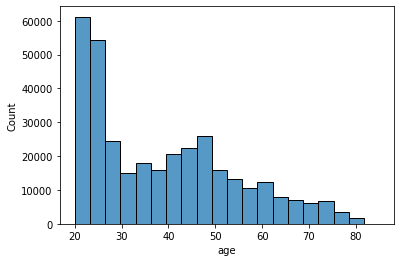

In [19]:
sns.histplot(df3['age'], bins=20);

Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.

In [20]:
índices, li, ls = buscar_outlier(df3, 'age')

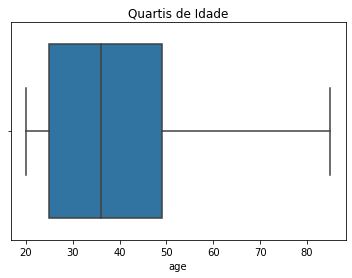

In [21]:
sns.boxplot(data=df3, x='age')
plt.title('Quartis de Idade');

sem outliers

In [22]:
print(f'A média de idade entre os que NÃO se interessam pelo produto: {round(df3.loc[df3["response"]==0, "age"].mean(), 2)}%')
print(f'A média de idade entre os que se interessam pelo produto: {round(df3.loc[df3["response"]==1, "age"].mean(), 2)}%')

A média de idade entre os que NÃO se interessam pelo produto: 38.17%
A média de idade entre os que se interessam pelo produto: 43.41%


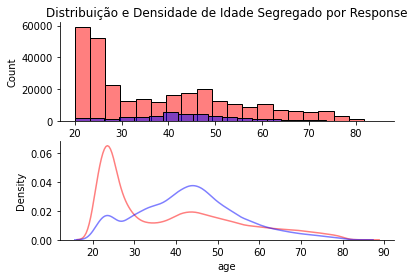

In [23]:
plt.subplot(2, 1, 1)
plt.title('Distribuição e Densidade de Idade Segregado por Response')
g = sns.histplot(df3.loc[df3['response']==0, 'age'], color='r', alpha=0.5, bins=20)
g = sns.histplot(df3.loc[df3['response']==1, 'age'], color='b', alpha=0.5, bins=20)
sns.despine()
plt.subplot(2, 1, 2)
g = sns.kdeplot(df3.loc[df3['response']==0, 'age'], color='r', alpha=0.5)
g = sns.kdeplot(df3.loc[df3['response']==1, 'age'], color='b', alpha=0.5)
sns.despine()

Pessoas mais velhas apresentam maior interesse no produto

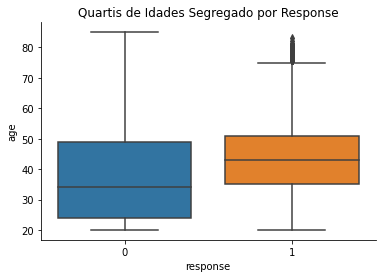

In [24]:
sns.boxplot(x='response', y='age', data=df3)
plt.title('Quartis de Idades Segregado por Response')
sns.despine();

Pessoas mais velhas apresentam interesse maior pelo produto

#### driving_license

In [25]:
print(f'{round(df3["driving_license"].mean(), 3)}% dos clientes são habilitados')

0.998% dos clientes são habilitados


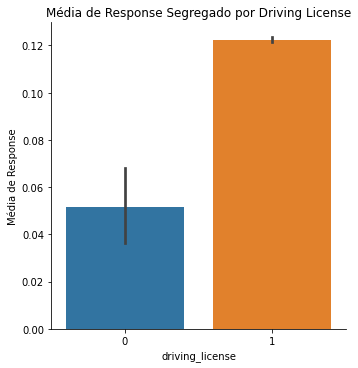

In [26]:
sns.catplot(x='driving_license', y= 'response', data=df3, kind='bar')
plt.ylabel('Média de Response')
plt.title('Média de Response Segregado por Driving License');

In [27]:
print(f'Habilitados tem: {round(df3.loc[df3["driving_license"]==0, "response"].mean()*100, 2)}% de interesse no produto')
print(f'NÃO habilitados tem: {round(df3.loc[df3["driving_license"]==1, "response"].mean()*100, 2)}% de interesse no produto')

Habilitados tem: 5.15% de interesse no produto
NÃO habilitados tem: 12.25% de interesse no produto


#### previously_insured

In [28]:
df3['previously_insured'].mean()

0.4584224980903679

45% dos clientes já sofreram danos veiculares

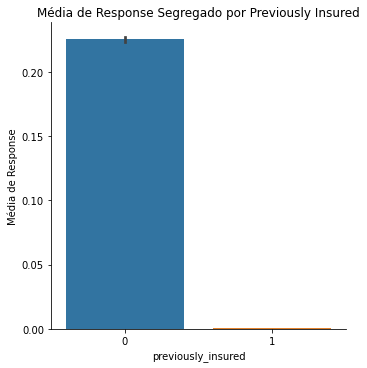

In [29]:
sns.catplot(x='previously_insured', y='response', data=df3, kind='bar')
plt.title('Média de Response Segregado por Previously Insured')
plt.ylabel('Média de Response');

In [30]:
df3.loc[df3['previously_insured']==1, 'response'].mean()*100

0.08840102265355704

Clientes que possuem seguro veicular tem interesse quase zero no produto

#### region_code

In [31]:
df3['region_code'].nunique()

53

53 categorias

In [32]:
df3['region_code'].value_counts(normalize=True).head(5)

28.0    0.278970
8.0     0.088566
46.0    0.051910
41.0    0.047857
15.0    0.034948
Name: region_code, dtype: float64

In [33]:
df3['region_code'].value_counts(normalize=True).head(5).sum()

0.5022507419868337

28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais densas.

In [34]:
df3.groupby('region_code', as_index=False).agg({'response':'mean'}).sort_values('response', ascending=False).head(5)

,region_code,response
38,38.0,0.193709
28,28.0,0.186360
23,23.0,0.156930
19,19.0,0.156919
4,4.0,0.153068


In [35]:
df3.groupby('region_code', as_index=False).agg({'response':'mean'}).sort_values('response', ascending=False).tail(5)

,region_code,response
16,16.0,0.065193
50,50.0,0.064457
10,10.0,0.060293
44,44.0,0.046154
25,25.0,0.043149


As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%

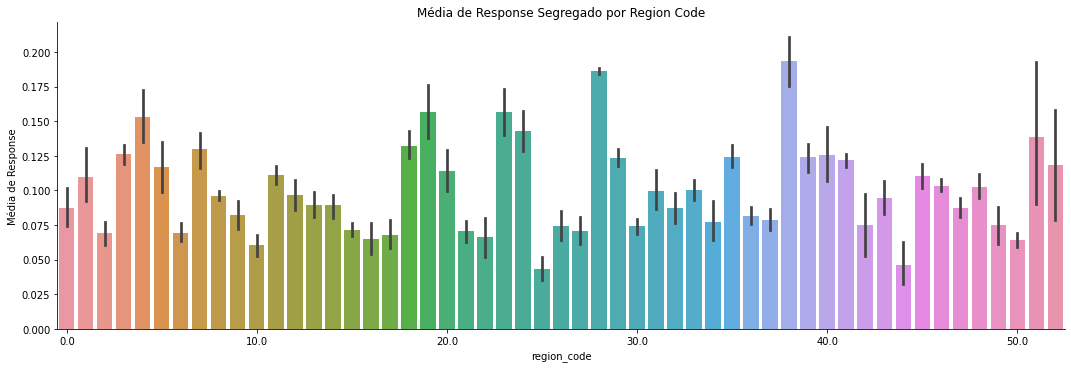

In [36]:
sns.catplot(x='region_code', y='response', data=df3, kind='bar', aspect=3)
plt.title('Média de Response Segregado por Region Code')
plt.xticks(range(0, int(df3['region_code'].max()), 10))
plt.ylabel('Média de Response');

Médias de response bastante distintas, com desvios padrões baixos

#### vehicle_age

In [37]:
df3['vehicle_age'].value_counts(normalize=True)

1-2 Year     0.525140
< 1 Year     0.432927
> 2 Years    0.041933
Name: vehicle_age, dtype: float64

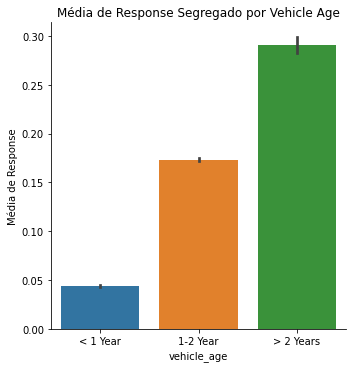

In [38]:
sns.catplot(x='vehicle_age', y='response', data=df3, kind='bar', order=['< 1 Year', '1-2 Year', '> 2 Years'])
plt.ylabel('Média de Response')
plt.title('Média de Response Segregado por Vehicle Age');

Médias de response bastante distintas

#### vehicle_damage

In [39]:
df3['vehicle_damage'].value_counts(normalize=True)

Yes    0.504437
No     0.495563
Name: vehicle_damage, dtype: float64

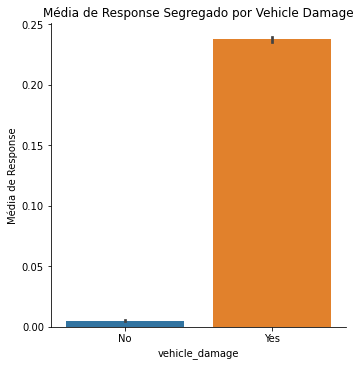

In [40]:
sns.catplot(x='vehicle_damage', y='response', data=df3, kind='bar')
plt.title('Média de Response Segregado por Vehicle Damage')
plt.ylabel('Média de Response');

In [41]:
print(f'Clientes que já tiveram danos tem: {round(df3.loc[df3["vehicle_damage"]=="Yes", "response"].mean()*100, 2)}% de response')
print(f'Clientes que NÃO tiveram danos tem: {round(df3.loc[df3["vehicle_damage"]=="No", "response"].mean()*100, 2)}% de response')

Clientes que já tiveram danos tem: 23.76% de response
Clientes que NÃO tiveram danos tem: 0.51% de response


Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

#### annual_premium

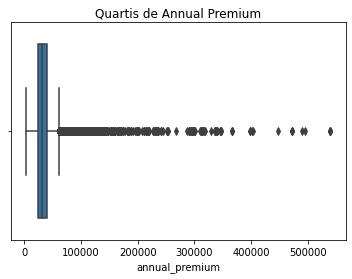

In [42]:
sns.boxplot(x='annual_premium', data=df3)
plt.title('Quartis de Annual Premium');

Muitos outliers

In [43]:
índices, li, ls = buscar_outlier(df3, 'annual_premium')

print(f'Há {len(índices)} outliers no total')

Há 1870 outliers no total


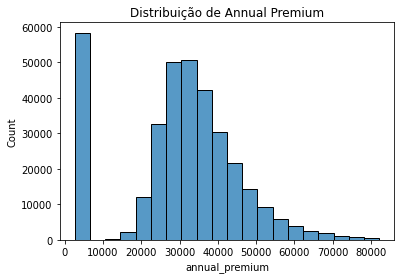

In [44]:
sns.histplot(df3.drop(índices)['annual_premium'], bins=20)
plt.title('Distribuição de Annual Premium');

Com exceção das amostras com valor mais baixo (fixo), a distribuição é bastante parecida com uma normal

In [45]:
df3['annual_premium'].value_counts(normalize=True).head(5)

2630.0     0.170024
69856.0    0.000373
39008.0    0.000108
38287.0    0.000105
38452.0    0.000099
Name: annual_premium, dtype: float64

17% dos clientes estão contidos em um valor discreto de 2630 dollares. Um estudo separadamente para este grupo pode ser interessante.

In [46]:
print(f'A média de interesse no produto do grupo de clientes com valor FIXO de seguro: {round(df3.loc[df3["annual_premium"]==2630, "response"].mean()*100, 2)}%')
print(f'A média de interesse no produto do grupo de clientes com valor VARIÁVEL SUPERIOR de seguro: {round(df3.loc[df3["annual_premium"]!=2630, "response"].mean()*100, 2)}%')

A média de interesse no produto do grupo de clientes com valor FIXO de seguro: 13.07%
A média de interesse no produto do grupo de clientes com valor VARIÁVEL SUPERIOR de seguro: 12.06%


O interesse no produto não é significativamente diferente entre os dois grupos de clientes

Para uma melhor visualização, os dados serão filtrados provisioriamente até 100000 dollares

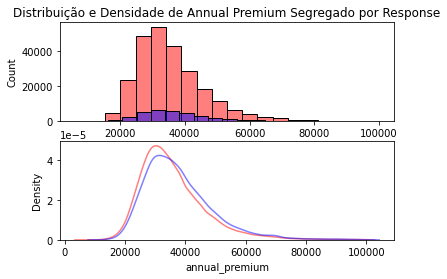

In [47]:
temp = df3.loc[(df3['annual_premium']>2630)&(df3['annual_premium']<100000)]

plt.subplot(2, 1, 1)
plt.title('Distribuição e Densidade de Annual Premium Segregado por Response')
g = sns.histplot(temp.loc[temp['response']==0, 'annual_premium'], color='r', alpha=0.5, bins=20)
g = sns.histplot(temp.loc[temp['response']==1, 'annual_premium'], color='b', alpha=0.5, bins=20)
plt.subplot(2, 1, 2)
g = sns.kdeplot(temp.loc[temp['response']==0, 'annual_premium'], color='r', alpha=0.5)
g = sns.kdeplot(temp.loc[temp['response']==1, 'annual_premium'], color='b', alpha=0.5)

Aparentemente acima do terceiro quartil da distribuição há um interesse maior no produto

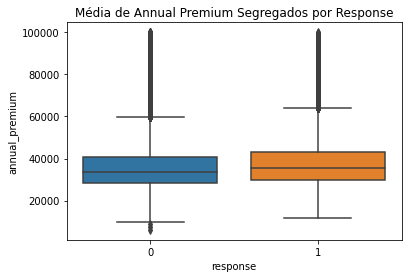

In [48]:
plt.title('Média de Annual Premium Segregados por Response')
sns.boxplot(x='response', y='annual_premium', data=temp);

Sem diferença significativa

#### policy_sales_channel

In [49]:
df3['policy_sales_channel'].value_counts(normalize=True).head(5)

152.0    0.354119
26.0     0.208902
124.0    0.194156
160.0    0.057271
156.0    0.027878
Name: policy_sales_channel, dtype: float64

In [50]:
canais_mais_utilizados = df3['policy_sales_channel'].value_counts(normalize=True).head(5).index

In [51]:
print(f'5 categorias contém {round(df3["policy_sales_channel"].value_counts(normalize=True).head(5).sum()*100, 2)}% do total de clientes')

5 categorias contém 84.23% do total de clientes


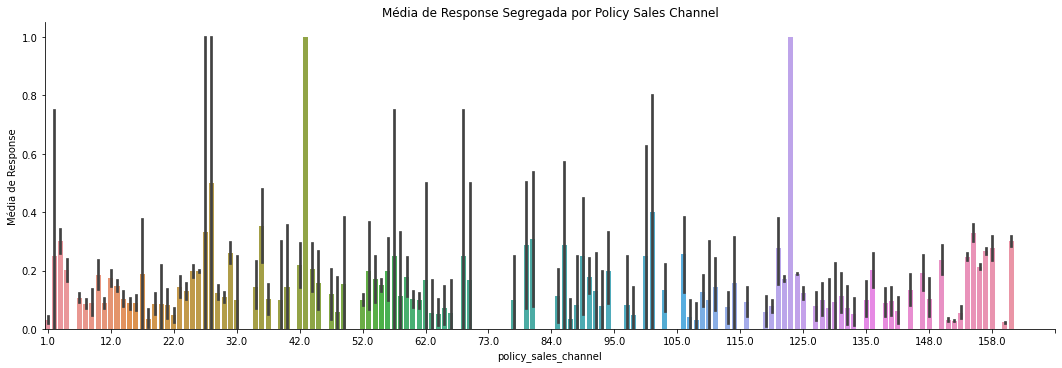

In [52]:
sns.catplot(x='policy_sales_channel', y='response', data=df3, kind='bar', aspect=3)
plt.xticks(range(0, int(df3['policy_sales_channel'].max()), 10))
plt.title('Média de Response Segregada por Policy Sales Channel')
plt.ylabel('Média de Response');

Médias de response por canais de Policy_Sales_Channel bastante distintas

In [53]:
temp = df3.groupby('policy_sales_channel', as_index=False).agg({'response':'count'})
temp.rename(columns={'response':'response_count'}, inplace=True)

temp2 = df3.groupby('policy_sales_channel', as_index=False).agg({'response':'mean'})
temp2.rename(columns={'response':'response_mean'}, inplace=True)

temp3 = temp.merge(temp2, how='left', on='policy_sales_channel')
temp3.sort_values('response_count', ascending=False).head(5)

,policy_sales_channel,response_count,response_mean
144,152.0,121462,0.028667
24,26.0,71653,0.198917
119,124.0,66595,0.189474
152,160.0,19644,0.022144
148,156.0,9562,0.213658


Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

#### vintage

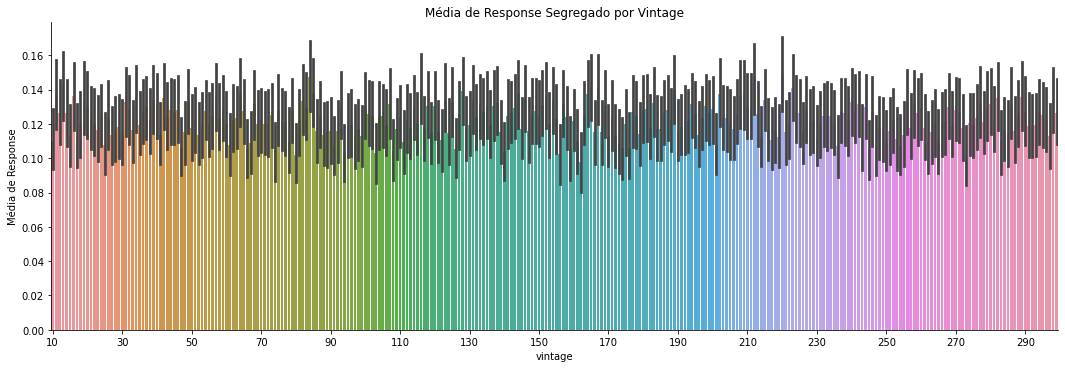

In [54]:
sns.catplot(x='vintage', y='response', data=df3, kind='bar', aspect=3)
plt.title('Média de Response Segregado por Vintage')
plt.ylabel('Média de Response')
plt.xticks(range(0, df3['vintage'].max(), 20));

Muito ruidoso, os desvios padrões colocam tudo no mesmo nível.

## 3.3 Bivariate Analysis

## 3.4 Multivariate Analysis

### 3.4.1 Numerical Attributes

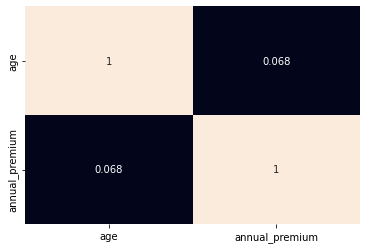

In [55]:
sns.heatmap(df3[numerical_attributes].corr(), annot=True, cbar=False);

### 3.4.1 Categorical Attributes

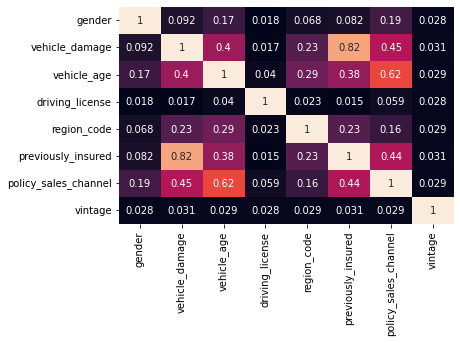

In [56]:
cramer_correlation = []

for i, col_1 in enumerate(categorical_attributes):
    for j, col_2 in enumerate(categorical_attributes):
        cramer_correlation.append(cramer_v(df3[col_1], df3[col_2]))
        
matrix = pd.DataFrame(np.array(cramer_correlation).reshape(8, 8), index=categorical_attributes, columns=categorical_attributes)

sns.heatmap(matrix, annot=True, cbar=False);

# 4.0 Data Filtering

In [57]:
df4 = df3.copy()

## 4.1 Columns

## 4.2 Rows

# 5.0 Data Preparation

In [58]:
# backup
df5 = df4.copy()

## 5.1 Normalization

In [59]:
# annual_premium
ss = StandardScaler()
ss_annual_premium = ss.fit(df5[['annual_premium']].values)
df5['annual_premium'] = ss_annual_premium.transform(df5[['annual_premium']].values)

annual_premium foi transformada pelo método standardscaler porque tem distribuição parecida com uma normal

## 5.2 Rescaling

In [60]:
# age by the method minmaxscaler
mm = MinMaxScaler()
mm_age = mm.fit(df5[['age']].values)
df5['age'] = mm_age.transform(df5[['age']].values)

age foi transformada pelo método minmaxscaler porque não parece com uma normal, e não houve necessidade de utilizar um método robusto contra outliers

## 5.3 Transformation

### 5.3.1 Encoding

In [61]:
# vehicle_age by the method labelencoding
map_vehicle_age = {'< 1 Year': 1, '1-2 Year': 2, '> 2 Years': 3}
df5['vehicle_age'] = df5['vehicle_age'].map(map_vehicle_age)

# gender
map_gender = {'Male':0, 'Female':1}
df5['gender'] = df5['gender'].map(map_gender)

# vehicle_damage
map_vehicle_damage = {'Yes':1, 'No':0}
df5['vehicle_damage'] = df5['vehicle_damage'].map(map_vehicle_damage)

# region_code by the method target_encoding
map_region_code = df5.groupby('region_code').agg({'response':'mean'})['response']
df5['region_code'] = df5['region_code'].map(map_region_code)

# policy_sales_channel
map_policy_sales_channel = df5.groupby('policy_sales_channel').agg({'response':'mean'})['response']
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(map_policy_sales_channel)

### 5.3.2 Nature Transformation

In [62]:
# vintage
cicle = df5['vintage'].max() - df5['vintage'].min()
df5['vintage_sin'] = df5['vintage'].apply(lambda x: np.sin(x* (2*np.pi/cicle)))
df5['vintage_cos'] = df5['vintage'].apply(lambda x: np.cos(x* (2*np.pi/cicle)))
df5.drop('vintage', axis=1, inplace=True)

## 5.4 Splitings

In [63]:
# spliting X and y
X = df5.drop(['response', 'id'], axis=1)
X = np.array(X)
y = df5['response'].copy()
y = np.array(y).reshape(1, len(y))[0]

# spliting train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

## 5.5 Balancing

In [64]:
smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## 5.6 Test Preparation

In [65]:
# lowercase columns
cols_lowercase = ' '.join(test.columns.to_list()).lower().split()
test.columns = cols_lowercase

# annual_premium
test['annual_premium'] = ss_annual_premium.transform(test[['annual_premium']].values)

# age by the method minmaxscaler
test['age'] = mm_age.transform(test[['age']].values)

# vehicle_age by the method labelencoding
test['vehicle_age'] = test['vehicle_age'].map(map_vehicle_age)

# gender
test['gender'] = test['gender'].map(map_gender)

# vehicle_damage
test['vehicle_damage'] = test['vehicle_damage'].map(map_vehicle_damage)

# region_code by the method target_encoding
test['region_code'] = test['region_code'].map(map_region_code)

# policy_sales_channel
test['policy_sales_channel'] = test['policy_sales_channel'].map(map_policy_sales_channel)

# vintage
cicle = test['vintage'].max() - test['vintage'].min()
test['vintage_sin'] = test['vintage'].apply(lambda x: np.sin(x* (2*np.pi/cicle)))
test['vintage_cos'] = test['vintage'].apply(lambda x: np.cos(x* (2*np.pi/cicle)))
test.drop('vintage', axis=1, inplace=True)

# dropna
test.dropna(inplace=True)

# 6.0 Feature Selection

In [66]:
df6 = df5.copy()

## 6.1 Importances

### 6.1.1 Random Forest

In [67]:
# model definition
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1000)

# fiting model
rf_fit = rf_model.fit(X_train_smote, y_train_smote)

# predicting
rf_predict = rf_fit.predict(X_val)

# metricss
print(classification_report(y_val, rf_predict))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     60202
           1       0.30      0.87      0.44      8398

    accuracy                           0.73     68600
   macro avg       0.63      0.79      0.63     68600
weighted avg       0.89      0.73      0.78     68600



### 6.1.2 XGBoost

In [68]:
# model_definition
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='error')

# fiting model
xgb_fit = xgb_model.fit(X_train_smote, y_train_smote)

# # predicting
xgb_predict = xgb_fit.predict(X_val)

# metricss
print(classification_report(y_val, xgb_predict))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93     60202
           1       0.40      0.16      0.22      8398

    accuracy                           0.87     68600
   macro avg       0.65      0.56      0.58     68600
weighted avg       0.83      0.87      0.84     68600



## 6.2 RFE

In [69]:
# model definition
rfe_model = RFE(rf_model, n_features_to_select=1)

# fiting model
rfe_fit = rfe_model.fit(X_train_smote, y_train_smote)

## 6.3 Boruta

In [70]:
# model definition
boruta_model = BorutaPy(rf_model)

# fiting model
boruta_fit = boruta_model.fit(X_train_smote, y_train_smote)

## 6.4 Defining

In [71]:
rf_importances = rf_fit.feature_importances_
xgb_importances = xgb_fit.feature_importances_
cols = df6.drop(['response', 'id'], axis=1).columns

importances = pd.DataFrame([cols, rf_importances, xgb_importances], index=['feature', 'rf_importance', 'xgb_importance']).T
importances

,feature,rf_importance,xgb_importance
0,gender,0.002437,0.001791
1,age,0.096591,0.030064
2,driving_license,0.0,0.008085
3,region_code,0.054399,0.035854
4,previously_insured,0.311875,0.456899
5,vehicle_age,0.039337,0.008417
6,vehicle_damage,0.308324,0.408044
7,annual_premium,0.004239,0.001653
8,policy_sales_channel,0.179624,0.045372
9,vintage_sin,0.000877,0.00137


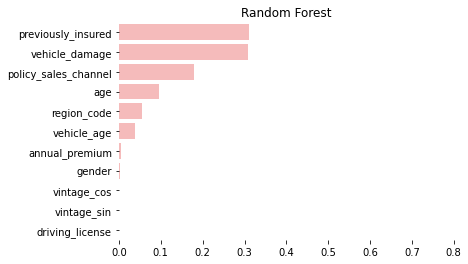

In [72]:
sns.barplot(data=importances.sort_values('rf_importance', ascending=False), x='rf_importance', y='feature', color='r', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.title('Random Forest')
plt.xlabel('')
plt.ylabel('')
plt.xlim(0, 0.8);

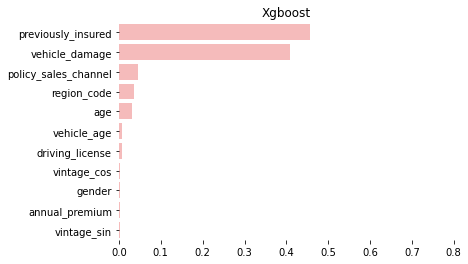

In [73]:
sns.barplot(data=importances.sort_values('xgb_importance', ascending=False), x='xgb_importance', y='feature', color='r', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.title('Xgboost')
plt.xlabel('')
plt.ylabel('')
plt.xlim(0, 0.8);

In [74]:
pd.DataFrame([cols, boruta_fit.ranking_, rfe_fit.ranking_], index=['feature', 'boruta_ranking', 'rfe_ranking']).T.sort_values('rfe_ranking')

,feature,boruta_ranking,rfe_ranking
6,vehicle_damage,1,1
4,previously_insured,1,2
8,policy_sales_channel,1,3
1,age,1,4
3,region_code,1,5
5,vehicle_age,1,6
7,annual_premium,1,7
0,gender,1,8
10,vintage_cos,1,9
9,vintage_sin,1,10


Utilizaremos as features: previously_insured, vehicle_damage, policy_sales_channel, age, region_code, vehicle_age e annual_premium

## 6.5 Droping Features

In [75]:
features_drop = 'driving_license vintage_sin vintage_cos gender'.split()

df6.drop(features_drop, axis=1, inplace=True)

test.drop(features_drop, axis=1, inplace=True)

# 7.0 Ml Modeling

In [76]:
df7 = df6.copy()

## 7.1 Preprocessing

In [77]:
# TRAIN
# spliting X and y
X = df7.drop(['response', 'id'], axis=1)
X = np.array(X)
y = df7['response'].copy()
y = np.array(y).reshape(1, len(y))[0]

# spliting train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

# balancing
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_smote, y_smote = smote.fit_resample(X, y)

# TEST
X_test = test.drop(['response', 'id'], axis=1)
X_test = np.array(X_test)
y_test = test['response'].copy()
y_test = np.array(y_test).reshape(1, len(y_test))[0]

## 7.2 Modeling

### 7.1 Random Forest

In [78]:
# VALIDATION
# fiting model
rf_fit = rf_model.fit(X_train_smote, y_train_smote)

# predicting
y_hat_rf = rf_fit.predict(X_val)

# metrics
print('TRAIN')
print(classification_report(y_val, y_hat_rf))
print('')

# TEST
# fiting model
rf_fit = rf_model.fit(X_smote, y_smote)

# predicting
y_hat_rf = rf_fit.predict(X_test)

# metrics
print('TEST')
print(classification_report(y_test, y_hat_rf))

# predict proba
proba_rf = rf_fit.predict_proba(X_test)

TRAIN
              precision    recall  f1-score   support

           0       0.98      0.68      0.81     60202
           1       0.29      0.92      0.44      8398

    accuracy                           0.71     68600
   macro avg       0.64      0.80      0.62     68600
weighted avg       0.90      0.71      0.76     68600


TEST
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     33362
           1       0.29      0.91      0.43      4748

    accuracy                           0.71     38110
   macro avg       0.63      0.79      0.62     38110
weighted avg       0.89      0.71      0.76     38110



Sem overfiting

### 7.2 XGboost

In [79]:
# VALIDATION
# fiting model
xgb_fit = xgb_model.fit(X_train_smote, y_train_smote)

# predicting
y_hat = xgb_fit.predict(X_val)

# metrics
print('TRAIN')
print(classification_report(y_val, y_hat))
print('')

# TEST
# fiting model
xgb_fit = xgb_model.fit(X_smote, y_smote)

# predicting
y_hat = xgb_fit.predict(X_test)

# metrics
print('TEST')
print(classification_report(y_test, y_hat))

# predict proba
proba_xgb = xgb_fit.predict_proba(X_test)

TRAIN
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     60202
           1       0.35      0.46      0.40      8398

    accuracy                           0.83     68600
   macro avg       0.64      0.67      0.65     68600
weighted avg       0.85      0.83      0.84     68600


TEST
              precision    recall  f1-score   support

           0       0.93      0.86      0.89     33362
           1       0.35      0.52      0.42      4748

    accuracy                           0.82     38110
   macro avg       0.64      0.69      0.65     38110
weighted avg       0.85      0.82      0.83     38110



Sem overfiting

### 7.3 Logistic Regression

In [80]:
# model definition
lr_model = LogisticRegression()

# VALIDATION
# fiting model
lr_fit = lr_model.fit(X_train_smote, y_train_smote)

# predicting
y_hat = lr_fit.predict(X_val)

# metrics
print('TRAIN')
print(classification_report(y_val, y_hat))
print('')

# TEST
# fiting model
lr_fit = lr_model.fit(X_smote, y_smote)

# predicting
y_hat = lr_fit.predict(X_test)

# metrics
print('TEST')
print(classification_report(y_test, y_hat))

# predict proba
proba_lr = lr_fit.predict_proba(X_test)

TRAIN
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     60202
           1       0.27      0.92      0.42      8398

    accuracy                           0.69     68600
   macro avg       0.63      0.79      0.61     68600
weighted avg       0.90      0.69      0.74     68600


TEST
              precision    recall  f1-score   support

           0       0.98      0.65      0.78     33362
           1       0.27      0.93      0.42      4748

    accuracy                           0.68     38110
   macro avg       0.63      0.79      0.60     38110
weighted avg       0.90      0.68      0.74     38110



Sem overfiting

# 8.0 Model Performance

In [81]:
def gain_curve_ktop_precision(df, target_variable, ktop=2000, new_clients=127000):
    proportional = df.shape[0] / new_clients
    ktop_proportional = ktop * proportional
    df.sort_values('propencity', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['ranking'] = df.index + 1
    df[f'cum_{target_variable}'] = np.cumsum(df[target_variable])
    df[f'percent_cum_{target_variable}'] = df[f'cum_{target_variable}'] / df['ranking']
    print(f"Precision at {ktop}: {round(float(df.loc[df['ranking']>=ktop_proportional, f'percent_cum_{target_variable}'].head(1).values)*100, 2)}%")

def gain_curve_ktop_recall(df, target_variable, ktop=2000, new_clients=127000):
    proportional = df.shape[0] / new_clients
    ktop_proportional = ktop * proportional
    df.sort_values('propencity', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['ranking'] = df.index + 1
    df[f'cum_{target_variable}'] = np.cumsum(df[target_variable])
    df[f'percent_cum_{target_variable}'] = df[f'cum_{target_variable}'] / df[target_variable].sum()
    print(f"Recall at {ktop}: {round(float(df.loc[df['ranking']>=ktop_proportional, f'percent_cum_{target_variable}'].head(1).values)*100, 2)}%")
    
def gain_curve_recall_recall(df, target_variable, recall=0.8, new_clients=127000):
    proportional = df.shape[0] / new_clients
    df.sort_values('propencity', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['ranking'] = df.index + 1
    df[f'cum_{target_variable}'] = np.cumsum(df[target_variable])
    df[f'percent_cum_{target_variable}'] = df[f'cum_{target_variable}'] / df[target_variable].sum()
    print(f"To achieve {round(recall*100, 2)}% of recall: {int(df.loc[df[f'percent_cum_{target_variable}']>=recall, 'ranking'].head(1).values/proportional)} will be needed")

In [82]:
df8 = test.copy()

df8 = df8[['id', 'response']]

### 8.1 Random Forest

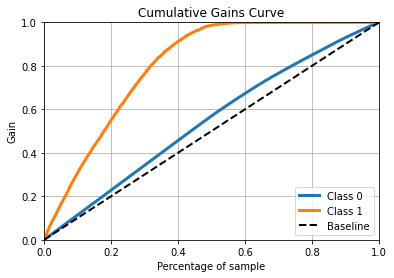

In [83]:
# ploting cumulative gain curve
skplt.metrics.plot_cumulative_gain(y_test, proba_rf);

In [84]:
df = df8.copy()
df['propencity'] = proba_rf[:,1]

gain_curve_ktop_precision(df, target_variable='response', ktop=20000, new_clients=127000)
gain_curve_ktop_recall(df, target_variable='response', ktop=20000, new_clients=127000)
gain_curve_recall_recall(df, target_variable='response', recall=0.8, new_clients=127000)

Precision at 20000: 35.59%
Recall at 20000: 44.99%
To achieve 80.0% of recall: 40466 will be needed


### 8.2 XGboost

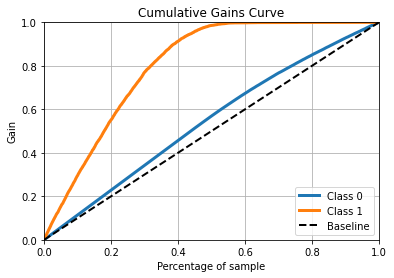

In [85]:
# ploting cumulative gain curve
skplt.metrics.plot_cumulative_gain(y_test, proba_xgb);

In [86]:
df = df8.copy()
df['propencity'] = proba_xgb[:,1]

gain_curve_ktop_precision(df, target_variable='response', ktop=20000, new_clients=127000)
gain_curve_ktop_recall(df, target_variable='response', ktop=20000, new_clients=127000)
gain_curve_recall_recall(df, target_variable='response', recall=0.8, new_clients=127000)

Precision at 20000: 35.29%
Recall at 20000: 44.61%
To achieve 80.0% of recall: 40499 will be needed


### 8.3 Logistic Regression

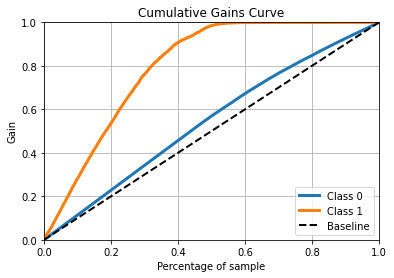

In [87]:
# ploting cumulative gain curve
skplt.metrics.plot_cumulative_gain(y_test, proba_lr);

In [88]:
df = df8.copy()
df['propencity'] = proba_lr[:,1]

gain_curve_ktop_precision(df, target_variable='response', ktop=20000, new_clients=127000)
gain_curve_ktop_recall(df, target_variable='response', ktop=20000, new_clients=127000)
gain_curve_recall_recall(df, target_variable='response', recall=0.8, new_clients=127000)

Precision at 20000: 34.37%
Recall at 20000: 43.45%
To achieve 80.0% of recall: 40862 will be needed


# 9.0 Results and Conclusions

In [89]:
df = df8.copy()
df['propencity'] = proba_rf[:,1]

### 9.1 Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

###### Vehicle Damage e Previously Insured são os atributos mais importante da base: 
Clientes que já possuem seguro de automóvel dificilmente fecharão um contrato. Clientes que já sofreram danos e acionaram o sinistro no passado são mais propensos a fechar um contrato.

###### Region Code é importante: 
A região 28 contém 28% da base e tem uma média de Response de 18% de negócios fechados, bem acima da média geral.

###### Sales Channel é importante:
Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

###### Age:
A média de idade entre os que não se interessam pelo produto é de 38 anos, e dos que se interessam é de 43 anos.

### 9.2 Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

In [90]:
gain_curve_ktop_recall(df, target_variable='response', ktop=20000, new_clients=127000)

Recall at 20000: 44.99%


### 9.3 E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

In [91]:
gain_curve_ktop_recall(df, target_variable='response', ktop=40000, new_clients=127000)

Recall at 40000: 79.28%


### 9.4 Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

In [92]:
gain_curve_recall_recall(df, target_variable='response', recall=0.8, new_clients=127000)

To achieve 80.0% of recall: 40466 will be needed


# 10.0 Exporting data

In [93]:
# annual_premium
pickle.dump(ss_annual_premium, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\ss_annual_premium.pkl', 'wb'))

# age
pickle.dump(mm_age, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\mm_age.pkl', 'wb'))

# vehicle_age
pickle.dump(map_vehicle_age, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\map_vehicle_age', 'wb'))

# gender
pickle.dump(map_gender, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\map_gender', 'wb'))

# vehicle_damage
pickle.dump(map_vehicle_damage, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\map_vehicle_damage', 'wb'))

# region_code
pickle.dump(map_region_code, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\map_region_code', 'wb'))

# policy_sales_channel
pickle.dump(map_policy_sales_channel, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\map_policy_sales_channel', 'wb'))

# features_remover
pickle.dump(features_drop, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\features_drop', 'wb'))

# Time

In [94]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-time_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 139 minutos
